# Sentiment Analysis Mini Challenge

> Arian Iseni, Christof Weickhardt, Oliver Pejic

> This notebook explores various strategies for Sentiment Analysis and Weak Labeling techniques, with a focus on optimizing feature extraction, fine-tuning, and evaluation metrics. It delves into different modeling approaches including baseline models, KNN, Random Forest, and Snorkel-like strategies for weak labeling. The notebook conducts thorough experiments to assess the performance of these methodologies across different dataset subsets, highlighting their impact on accuracy and model efficiency.

- [Description of the task](https://spaces.technik.fhnw.ch/storage/uploads/spaces/81/exercises/NPR-Mini-Challenge-2-Sentiment-Analysis-1726328684.pdf)
- [Introduction Sentiment Classification](https://spaces.technik.fhnw.ch/storage/uploads/spaces/81/exercises/Introduction-Sentiment-MC-1729000628.pdf)

# Table of Contents

- [Sentiment Analysis Mini Challenge](#sentiment-analysis-mini-challenge)
- [Introduction](#introduction)
- [Dataset](#dataset)
    - [Data Fields](#data-fields)
  - [Data Sampling](#data-sampling)
  - [Data Exploration](#data-exploration)
- [Feature Extraction and Fine-Tuning](#feature-extraction-and-fine-tuning)
  - [Baseline Model Performance](#baseline-model-performance)
  - [Feature Extraction](#feature-extraction)
- [Fine-Tuning Model](#fine-tuning-model)
  - [Training both Feature Extraction and Fine-Tuning](#training-both-feature-extraction-and-fine-tuning)
  - [Results](#results)
  - [Analysis](#analysis)
    - [Baseline Model:](#baseline-model)
    - [Feature Extraction:](#feature-extraction)
    - [Fine-Tuning](#fine-tuning)
  - [Conclusion](#conclusion)
- [Weak Labeling](#weak-labeling)
  - [Weak Labeling Strategies](#weak-labeling-strategies)
  - [KNN Weak Labeling](#knn-weak-labeling)
  - [Random Forest Weak Labeling](#random-forest-weak-labeling)
  - [Snorkel-Like Weak Labeling](#snorkel-like-weak-labeling)
- [Overall Conclusions](#overall-conclusions)
- [Analysis of Accuracy vs Subset Size (All Approaches)](#analysis-of-accuracy-vs-subset-size-all-approaches)
  - [1. Feature Extraction](#1-feature-extraction)
  - [2. Fine-Tuning](#2-fine-tuning)
  - [3. Baseline Model](#3-baseline-model)
  - [4. Weak Label: KNN](#4-weak-label-knn)
  - [5. Weak Label: Random Forest](#5-weak-label-random-forest)
  - [6. Weak Label: Snorkel](#6-weak-label-snorkel)
  - [Overall Observations](#overall-observations)
  - [Recommendations](#recommendations)
- [Analyzing Embeddings](#analyzing-embeddings)
  - [Observations:](#observations)
  - [Observations:](#observations)
  - [Observations:](#observations)
- [Enhancing Our Project with AI Assistive Tools](#enhancing-our-project-with-ai-assistive-tools)


## Introduction

Sentiment analysis, also known as opinion mining, is a subfield of natural language processing (NLP) that focuses on identifying and categorizing the emotional tone conveyed in a piece of text. It aims to determine whether the sentiment expressed is positive, negative, neutral, or falls into other nuanced categories like anger, joy, or fear. This technique is widely used in applications such as social media monitoring, customer feedback analysis, market research, and even in gauging public opinion on political events or products.

# Dataset

For this challenge we used the [Amazon Polarity dataset](https://huggingface.co/datasets/fancyzhx/amazon_polarity). The Dataset contains 4 million reviews.

### Data Fields

- 'title': a string containing the title of the review - escaped using double quotes (") and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".
- 'content': a string containing the body of the document - escaped using double quotes (") and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".
- 'label': either 1 (positive) or 0 (negative) rating.

## Data Sampling

In [1]:
from datasets import load_dataset, concatenate_datasets
from tqdm.notebook import tqdm
from dotenv import load_dotenv
import src.utils as utils
from collections import Counter
import random
import matplotlib.pyplot as plt

load_dotenv()

# Load the dataset
dataset = load_dataset("fancyzhx/amazon_polarity")
train_data = dataset["train"]
test_data = dataset["test"]

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-12-20 22:21:12.083257: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 22:21:12.101857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734733272.125223    7768 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734733272.132136    7768 cuda_blas.cc:1418] Unable to register cuBL

In [2]:
train_data.shape, test_data.shape

((3600000, 3), (400000, 3))

In [3]:
train_labels = train_data.to_pandas()["label"]
test_labels = test_data.to_pandas()["label"]

The Ratio of the train and test data is 90% and 10% respectively. We will use the same ration in our splits.

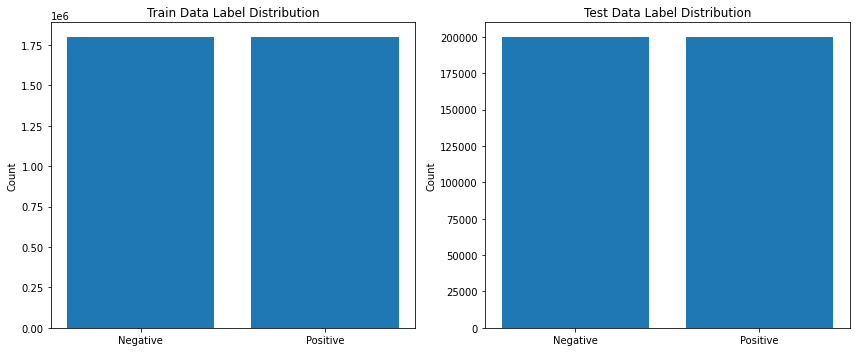

Train data distribution: Counter({1: 1800000, 0: 1800000})
Test data distribution: Counter({1: 200000, 0: 200000})


In [4]:
# Plot distribution of labels
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Train data distribution
train_counts = Counter(train_labels)
ax1.bar(["Negative", "Positive"], [train_counts[0], train_counts[1]])
ax1.set_title("Train Data Label Distribution")
ax1.set_ylabel("Count")

# Test data distribution
test_counts = Counter(test_labels)
ax2.bar(["Negative", "Positive"], [test_counts[0], test_counts[1]])
ax2.set_title("Test Data Label Distribution")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

print("Train data distribution:", train_counts)
print("Test data distribution:", test_counts)

The balance of the dataset is good. We have an equal number of positive and negative samples. So we don't need to balance the dataset.

In [20]:
SEED = 2277
sizes = [100, 200, 400, 600, 800, 1000]

# Set random seed for reproducibility
random.seed(SEED)
shuffled_data = train_data.shuffle(seed=SEED)

constructive_train_subsets = {}
constructive_test_subsets = {}

for size in sizes:
    train_size = int(size)  # 90% for train
    test_size = int(size * 0.1)  # 10% for test

    # Add additional samples to the train and test subsets
    # additional_train_samples = shuffled_data.select(range(len(current_train_subset), len(current_train_subset) + train_size))
    # additional_test_samples = test_data.select(range(len(current_test_subset), len(current_test_subset) + test_size))

    # Update the current subsets
    # current_train_subset = concatenate_datasets([current_train_subset, additional_train_samples])
    # current_test_subset = concatenate_datasets([current_test_subset, additional_test_samples])

    print(shuffled_data.select(range(0, train_size)).shape)

    # Store the subsets
    constructive_train_subsets[size] = shuffled_data.select(range(0, train_size))
    constructive_test_subsets[size] = test_data.select(range(0, test_size))

(100, 3)
(200, 3)
(400, 3)
(600, 3)
(800, 3)
(1000, 3)


We sampled the data in different sizes to see how the model performs with different amounts of data. We will use these subsets to train the model and evaluate the performance.

First we'll save the subsets as json files.

In [21]:
for size, subset in constructive_train_subsets.items():
    subset.to_json(f"data/subset/train_subset_{size}.json")

for size, subset in constructive_test_subsets.items():
    subset.to_json(f"data/subset/test_subset_{size}.json")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

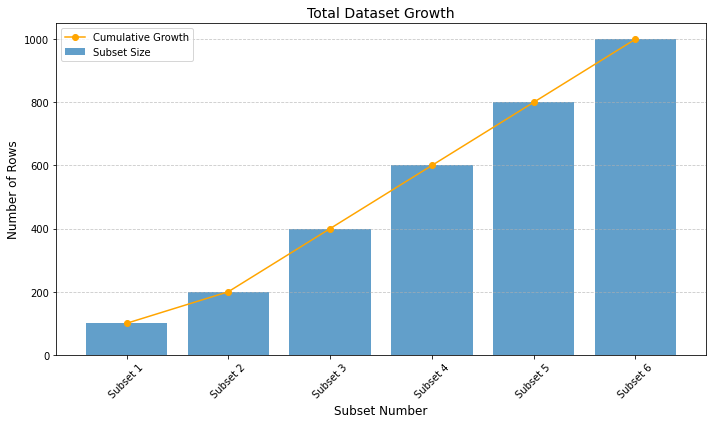

In [22]:
# Plot 1: Total dataset growth
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(sizes)), sizes, marker="o", label="Cumulative Growth", color="orange"
)
plt.bar(
    range(len(sizes)),
    [len(ds) for s, ds in constructive_train_subsets.items()],
    alpha=0.7,
    tick_label=sizes,
    label="Subset Size",
)
plt.xlabel("Subset Number", fontsize=12)
plt.ylabel("Number of Rows", fontsize=12)
plt.title("Total Dataset Growth", fontsize=14)
plt.xticks(
    range(len(sizes)), labels=[f"Subset {i+1}" for i in range(len(sizes))], rotation=45
)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

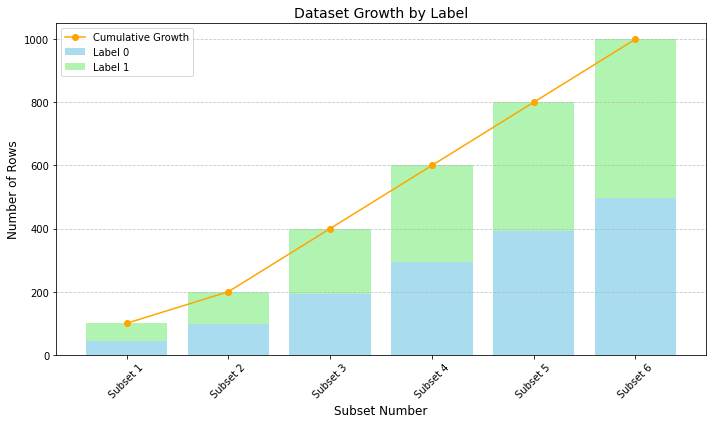

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(sizes)), sizes, marker="o", label="Cumulative Growth", color="orange"
)

label_0_counts = [
    len([x for x in ds if x["label"] == 0])
    for s, ds in constructive_train_subsets.items()
]
label_1_counts = [
    len([x for x in ds if x["label"] == 1])
    for s, ds in constructive_train_subsets.items()
]

plt.bar(
    range(len(sizes)),
    label_0_counts,
    alpha=0.7,
    tick_label=sizes,
    label="Label 0",
    color="skyblue",
)
plt.bar(
    range(len(sizes)),
    label_1_counts,
    alpha=0.7,
    tick_label=sizes,
    label="Label 1",
    color="lightgreen",
    bottom=label_0_counts,
)
plt.xlabel("Subset Number", fontsize=12)
plt.ylabel("Number of Rows", fontsize=12)
plt.title("Dataset Growth by Label", fontsize=14)
plt.xticks(
    range(len(sizes)), labels=[f"Subset {i+1}" for i in range(len(sizes))], rotation=45
)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Data exploration

For this small data exploration, we will concatenate all subsets and use them to get a better understanding of the data.

In [24]:
import pandas as pd

eda_df = pd.DataFrame()

for size, subset in constructive_train_subsets.items():
    subset_df = pd.DataFrame(subset)  # Convert Hugging Face Dataset to Pandas DataFrame
    subset_df["subset_size"] = size  # Add a column to track the subset source
    eda_df = pd.concat([eda_df, subset_df], ignore_index=True)

# Display the structure of the concatenated dataset
eda_df.head()

,label,title,content,subset_size
0,0,Why rely on facts?,An interesting book which was moulded by the d...,100
1,0,Will NOT work with Win98se,Tech support states that this card is known NO...,100
2,0,Cheaply Made but $$$ priced,It is barely September and the Dock already st...,100
3,1,A Wonderful Learning Tool,Even though I already had a thuro understandin...,100
4,1,Daughter loves it; does not turn her brain int...,"OK, this is Barbie, not high art. Clearly, the...",100


In [25]:
eda_df.shape

(3100, 4)

In [26]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download("stopwords")

# Define stopwords
stop_words = set(stopwords.words("english"))


# Function to tokenize and filter stopwords
def tokenize_and_filter(text):
    words = text.lower().split()  # Simple split
    return [word for word in words if word.isalnum() and word not in stop_words]


# Tokenize content by label
eda_df["tokens"] = eda_df["content"].apply(tokenize_and_filter)

# Separate positive and negative labels
positive_words = Counter(
    [word for tokens in eda_df[eda_df["label"] == 1]["tokens"] for word in tokens]
)
negative_words = Counter(
    [word for tokens in eda_df[eda_df["label"] == 0]["tokens"] for word in tokens]
)

# Get most common words
common_positive = positive_words.most_common(20)
common_negative = negative_words.most_common(20)

# Print results
print("Most Common Words for Positive Labels:")
print(common_positive)

print("\nMost Common Words for Negative Labels:")
print(common_negative)

Most Common Words for Positive Labels:
[('book', 566), ('great', 458), ('one', 412), ('like', 331), ('would', 293), ('good', 288), ('best', 242), ('get', 228), ('read', 221), ('love', 221), ('also', 205), ('really', 179), ('first', 176), ('even', 169), ('much', 163), ('new', 156), ('buy', 156), ('recommend', 148), ('time', 146), ('cd', 146)]

Most Common Words for Negative Labels:
[('book', 520), ('like', 490), ('would', 443), ('one', 427), ('get', 376), ('really', 297), ('good', 262), ('even', 247), ('movie', 204), ('read', 203), ('time', 200), ('could', 199), ('much', 181), ('make', 179), ('first', 178), ('better', 171), ('two', 171), ('never', 168), ('buy', 164), ('use', 164)]


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


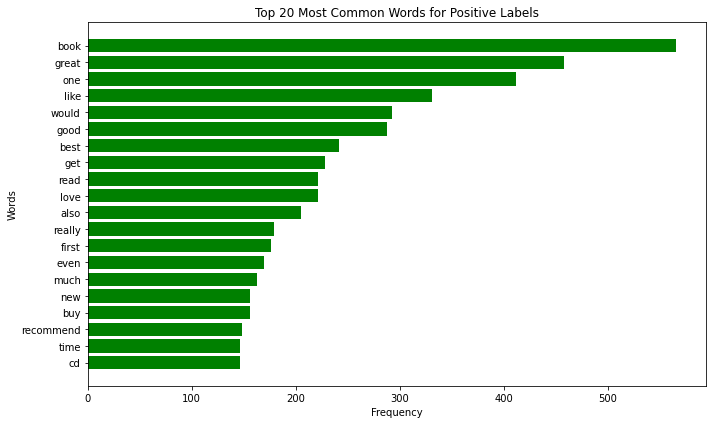

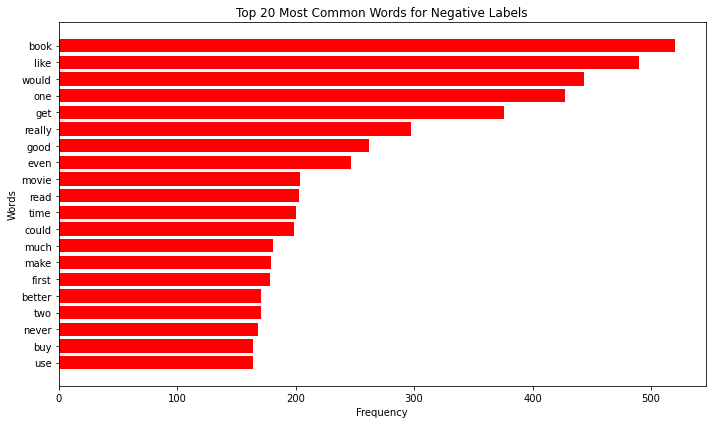

In [27]:
# Bar chart for positive words
positive_df = pd.DataFrame(common_positive, columns=["Word", "Count"])
plt.figure(figsize=(10, 6))
plt.barh(positive_df["Word"], positive_df["Count"], color="green")
plt.title("Top 20 Most Common Words for Positive Labels")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.tight_layout()
plt.show()

# Bar chart for negative words
negative_df = pd.DataFrame(common_negative, columns=["Word", "Count"])
plt.figure(figsize=(10, 6))
plt.barh(negative_df["Word"], negative_df["Count"], color="red")
plt.title("Top 20 Most Common Words for Negative Labels")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.tight_layout()
plt.show()

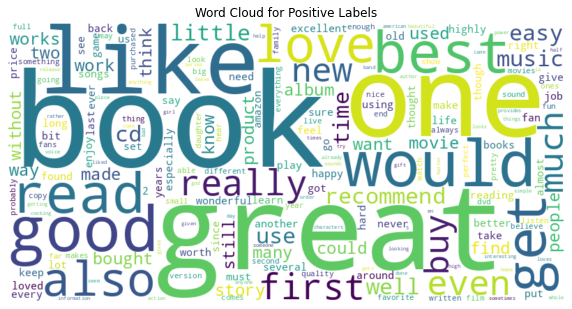

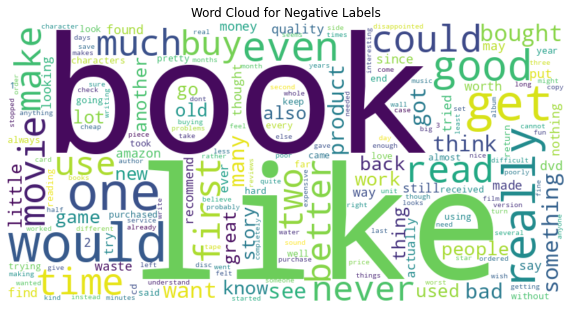

In [28]:
# Word clouds
positive_wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate_from_frequencies(positive_words)
negative_wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate_from_frequencies(negative_words)

# Plot positive word cloud
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Labels")
plt.show()

# Plot negative word cloud
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Labels")
plt.show()

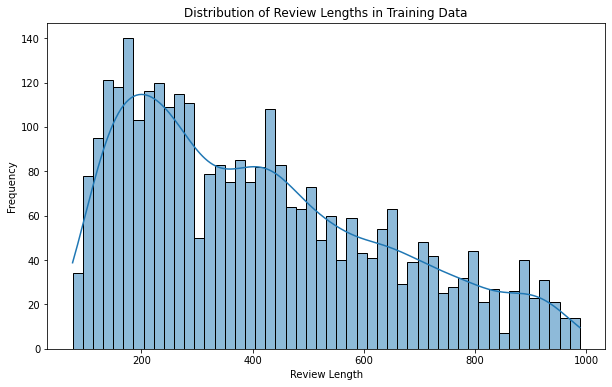

In [29]:
import seaborn as sns

eda_df["review_length"] = eda_df["content"].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(eda_df["review_length"], bins=50, kde=True)
plt.title("Distribution of Review Lengths in Training Data")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.show()

---

# Feature Extraction and Fine-Tuning

This section outlines the methodology employed for training the models. All model training processes are implemented directly within the provided notebook, leveraging the flexibility and integration of the transformers library.

We utilize the distilbert-base-uncased model, which is pretrained on a diverse corpus of text data. The training involves two approaches: Feature Extraction and Fine-Tuning, each adapted to specific training objectives.
- Feature Extraction: In this approach, the pretrained model’s weights are frozen, and it is used solely as a feature extractor. Only the classification head on top of the model is trained on the labeled dataset, ensuring the core model remains unchanged.
- Fine-Tuning: Here, the entire model, including both the pretrained layers and the classification head, is trained on the labeled dataset. All weights are updated during the training process to adapt the model fully to the task at hand.

The primary distinction between these methods lies in the weights that are updated during training, while the overall training process remains consistent.

For tokenization, we rely on the transformers library’s built-in tokenizer tailored for distilbert-base-uncased. The tokenizer processes the input text into tokenized representations that are compatible with the model architecture.

The training is conducted locally on MacBook systems, using Optuna for hyperparameter tuning to optimize performance. This approach ensures the hyperparameters are tailored to the dataset and task requirements, resulting in better model performance.

## Baseline Model Performance

In [30]:
import json
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter  # For counting labels
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

model_name = "distilbert-base-uncased"


def extract_baseline_embeddings(subset, model_name, save_path, size):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to("cuda")
    print(model.device)
    model.eval()

    embeddings = []
    labels = []

    for item in subset:
        inputs = tokenizer(
            item["content"],
            truncation=True,
            padding="max_length",
            return_tensors="pt",
            max_length=512,
        ).to("cuda")
        with torch.no_grad():
            outputs = model(**inputs)
            embedding = (
                outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            )  # Average embedding
            embeddings.append(embedding)
            labels.append(item["label"])

    np.save(f"{save_path}/baseline_embeddings_{size}.npy", np.array(embeddings))
    np.save(f"{save_path}/baseline_labels_{size}.npy", np.array(labels))
    print(f"Baseline embeddings saved for size {size}.")


def baseline_majority_vote_model(test_data):
    """
    Predict the majority class as the baseline.
    """
    # Find the most frequent label in the test data
    label_counts = Counter(test_data["label"])
    print(test_data)
    most_frequent_label = label_counts.most_common(1)[0][0]
    predictions = [most_frequent_label] * len(test_data["label"])
    return predictions

In [31]:
# Containers to store results
baseline_accuracy = {}
baseline_f1 = {}

# Iterate over the constructive subsets
for size in tqdm(sizes):
    print(
        size,
        constructive_test_subsets[size].shape,
        constructive_train_subsets[size].shape,
    )
    test_subset = constructive_test_subsets[size]
    train_subset = constructive_train_subsets[size]

    # Run the baseline model on the test subset
    baseline_predictions = baseline_majority_vote_model(test_subset)
    precision, recall, f1, _ = precision_recall_fscore_support(
        test_subset["label"], baseline_predictions, average="binary", zero_division=0
    )
    acc = accuracy_score(test_subset["label"], baseline_predictions)

    # Store results
    baseline_accuracy[size] = acc
    baseline_f1[size] = f1

    # Combine results into a dictionary for this size
    baseline_results = {
        "accuracy": acc,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
    }
    print("Extracting embeddings")

    extract_baseline_embeddings(
        test_subset, model_name=model_name, save_path="embeddings", size=size
    )

    # Save the results to a JSON file
    with open(f"eval/baseline_results_{size}.json", "w") as json_file:
        json.dump(baseline_results, json_file, indent=4)

print("Baseline results saved for all sizes.")

  0%|          | 0/6 [00:00<?, ?it/s]

100 (10, 3) (100, 3)
Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 10
})
Extracting embeddings
cuda:0
Baseline embeddings saved for size 100.
200 (20, 3) (200, 3)
Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 20
})
Extracting embeddings
cuda:0
Baseline embeddings saved for size 200.
400 (40, 3) (400, 3)
Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 40
})
Extracting embeddings
cuda:0
Baseline embeddings saved for size 400.
600 (60, 3) (600, 3)
Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 60
})
Extracting embeddings
cuda:0
Baseline embeddings saved for size 600.
800 (80, 3) (800, 3)
Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 80
})
Extracting embeddings
cuda:0
Baseline embeddings saved for size 800.
1000 (100, 3) (1000, 3)
Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 100
})
Extracting embeddings
cuda:0
Baseline embeddings saved for size 1000.
Basel

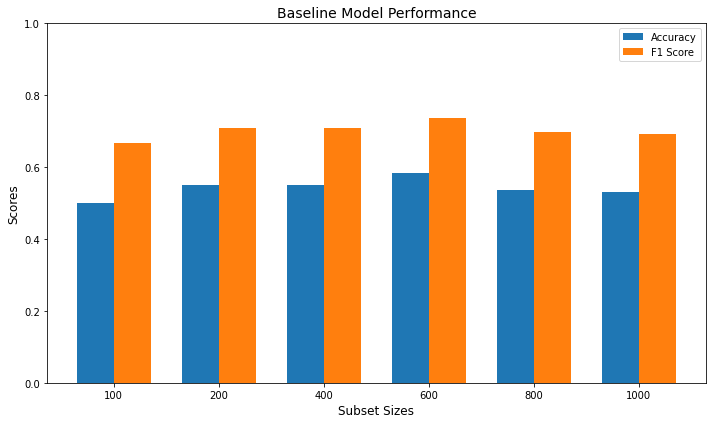

In [32]:
subset_sizes = list(baseline_accuracy.keys())

accuracies = list(baseline_accuracy.values())
f1_scores = list(baseline_f1.values())

# Bar width
bar_width = 0.35
indices = np.arange(len(subset_sizes))

# Create the bar plot
plt.figure(figsize=(10, 6))

# Accuracy bars
plt.bar(indices - bar_width / 2, accuracies, bar_width, label="Accuracy")

# F1 score bars
plt.bar(indices + bar_width / 2, f1_scores, bar_width, label="F1 Score")

# Add labels and title
plt.xlabel("Subset Sizes", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Baseline (Majority vote) Model Performance", fontsize=14)
plt.xticks(indices, subset_sizes)
plt.ylim(0, 1)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Feature Extraction

In [33]:
from datasets import Dataset
import src.utils as utils


def tokenize_data(batch):
    """
    Tokenize the dataset using the tokenizer.
    """
    return utils.tokenizer(
        batch["content"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )


# Prepare datasets for a specific size
def prepare_datasets(size):
    """
    Prepare tokenized Hugging Face Datasets from the constructive subsets.
    """
    train_df = constructive_train_subsets[size].to_pandas()
    test_df = constructive_test_subsets[size].to_pandas()

    train_dataset = Dataset.from_pandas(train_df).map(tokenize_data, batched=True)
    test_dataset = Dataset.from_pandas(test_df).map(tokenize_data, batched=True)
    return train_dataset, test_dataset

In [42]:
def train_with_feature_extraction(size, train_dataset, test_dataset):
    # Load a pre-trained model
    model = utils.get_model().to("cuda")

    # Freeze all layers of the main model (not the classifier)
    for name, param in model.base_model.named_parameters():
        param.requires_grad = False

    training_args = TrainingArguments(
        output_dir="outputs/results",
        eval_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=3.227478802173934e-05,
        # per_device_train_batch_size=128,
        per_device_eval_batch_size=32,
        # num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="outputs/logs",
        save_strategy="epoch",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        processing_class=utils.tokenizer,
        compute_metrics=utils.compute_metrics,
    )

    # Train and evaluate
    print(f"Training with Feature Extraction for Subset {size}")
    trainer.train()
    eval_results = trainer.evaluate()

    # Save evaluation results to a JSON file
    with open(f"eval/eval_results_feature_extraction_{size}.json", "w") as f:
        json.dump(eval_results, f)

    outputs = trainer.predict(test_dataset)
    embeddings = outputs.predictions
    np.save(f"embeddings/feature_extraction_embeddings_{size}.npy", embeddings)
    print(f"Feature extraction embeddings saved for size {size}.")
    trainer.save_model(f"models/feature_extraction_model_{size}")

    print(f"Feature Extraction Results for Subset {size} saved.")

## Fine-Tuning Model

In [43]:
def train_with_fine_tuning(size, train_dataset, test_dataset):
    model = utils.get_model().to("cuda")
    # Initialize Trainer
    trainer = Trainer(
        model=model,  # Assumes a pre-loaded model is available in utils
        args=TrainingArguments(
            output_dir="outputs/results",
            eval_strategy="epoch",
            logging_strategy="epoch",
            learning_rate=3.227478802173934e-05,
            # per_device_train_batch_size=128,
            per_device_eval_batch_size=32,
            # num_train_epochs=10,
            weight_decay=0.01,
            logging_dir="outputs/logs",
            save_strategy="epoch",
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
        ),
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        processing_class=utils.tokenizer,
        compute_metrics=utils.compute_metrics,
    )

    # Train and evaluate
    print(f"Training with Fine-Tuning for Subset {size}")
    trainer.train()
    eval_results = trainer.evaluate()

    # Save evaluation results to a JSON file
    with open(f"eval/eval_results_fine_tuning_{size}.json", "w") as f:
        json.dump(eval_results, f)

    outputs = trainer.predict(test_dataset)
    # print(outputs.last_hidden_state)
    embeddings = outputs.predictions
    np.save(f"embeddings/fine_tuning_embeddings_{size}.npy", embeddings)
    print(f"Fine-tuning embeddings saved for size {size}.")
    trainer.save_model(f"models/fine_tuned_model_{size}")

    print(f"Fine-Tuning Results for Subset {size} saved.")

### Training both Feature Extraction and Fine-Tuning

In [44]:
base_tunes_dataset = {}

for size in sizes:
    # Prepare datasets
    train_dataset, test_dataset = prepare_datasets(size)

    # Train with feature extraction
    train_with_feature_extraction(size, train_dataset, test_dataset)

    # Train with fine-tuning
    train_with_fine_tuning(size, train_dataset, test_dataset)

    # train_with_lora_tuning(size, train_dataset, test_dataset)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with Feature Extraction for Subset 100


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.692600,0.694910,0.500000,0.615385,0.500000,0.800000
2,0.681700,0.693917,0.500000,0.666667,0.500000,1.000000
3,0.680200,0.692794,0.500000,0.666667,0.500000,1.000000


Feature extraction embeddings saved for size 100.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature Extraction Results for Subset 100 saved.
Training with Fine-Tuning for Subset 100


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.694800,0.678371,0.500000,0.666667,0.500000,1.000000
2,0.627900,0.645703,0.700000,0.769231,0.625000,1.000000
3,0.543800,0.613492,0.800000,0.833333,0.714286,1.000000


Fine-tuning embeddings saved for size 100.
Fine-Tuning Results for Subset 100 saved.


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with Feature Extraction for Subset 200


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.690200,0.675869,0.600000,0.733333,0.578947,1.000000
2,0.678700,0.665709,0.750000,0.800000,0.714286,0.909091
3,0.676100,0.662585,0.800000,0.833333,0.769231,0.909091


Feature extraction embeddings saved for size 200.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature Extraction Results for Subset 200 saved.
Training with Fine-Tuning for Subset 200


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.686900,0.619788,0.750000,0.800000,0.714286,0.909091
2,0.528200,0.443309,0.850000,0.880000,0.785714,1.000000
3,0.295500,0.403410,0.850000,0.880000,0.785714,1.000000


Fine-tuning embeddings saved for size 200.
Fine-Tuning Results for Subset 200 saved.


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with Feature Extraction for Subset 400


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.692000,0.665274,0.625000,0.736842,0.600000,0.954545
2,0.668200,0.648807,0.725000,0.784314,0.689655,0.909091
3,0.659200,0.643713,0.750000,0.800000,0.714286,0.909091


Feature extraction embeddings saved for size 400.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature Extraction Results for Subset 400 saved.
Training with Fine-Tuning for Subset 400


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.589800,0.396132,0.850000,0.857143,0.900000,0.818182
2,0.274200,0.427655,0.850000,0.875000,0.807692,0.954545
3,0.110100,0.550909,0.825000,0.857143,0.777778,0.954545


Fine-tuning embeddings saved for size 400.
Fine-Tuning Results for Subset 400 saved.


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with Feature Extraction for Subset 600


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.682700,0.661257,0.750000,0.788732,0.777778,0.800000
2,0.657800,0.641897,0.800000,0.837838,0.794872,0.885714
3,0.646200,0.637636,0.800000,0.828571,0.828571,0.828571


Feature extraction embeddings saved for size 600.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature Extraction Results for Subset 600 saved.
Training with Fine-Tuning for Subset 600


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.555500,0.416435,0.850000,0.883117,0.809524,0.971429
2,0.233900,0.404394,0.850000,0.869565,0.882353,0.857143
3,0.097900,0.485669,0.866667,0.888889,0.864865,0.914286


Fine-tuning embeddings saved for size 600.
Fine-Tuning Results for Subset 600 saved.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with Feature Extraction for Subset 800


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.678800,0.655115,0.775000,0.769231,0.857143,0.697674
2,0.642900,0.629712,0.750000,0.782609,0.734694,0.837209
3,0.627000,0.622965,0.787500,0.800000,0.809524,0.790698


Feature extraction embeddings saved for size 800.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Feature Extraction Results for Subset 800 saved.
Training with Fine-Tuning for Subset 800


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.500700,0.469616,0.812500,0.842105,0.769231,0.930233
2,0.221500,0.466140,0.850000,0.863636,0.844444,0.883721
3,0.096700,0.537030,0.837500,0.850575,0.840909,0.860465


Fine-tuning embeddings saved for size 800.
Fine-Tuning Results for Subset 800 saved.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with Feature Extraction for Subset 1000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.671400,0.649007,0.810000,0.815534,0.840000,0.792453
2,0.630100,0.621516,0.810000,0.815534,0.840000,0.792453
3,0.610400,0.611849,0.810000,0.819048,0.826923,0.811321


Feature extraction embeddings saved for size 1000.
Feature Extraction Results for Subset 1000 saved.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with Fine-Tuning for Subset 1000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.458500,0.446110,0.850000,0.862385,0.839286,0.886792
2,0.233500,0.520842,0.850000,0.862385,0.839286,0.886792
3,0.095000,0.576695,0.860000,0.870370,0.854545,0.886792


Fine-tuning embeddings saved for size 1000.
Fine-Tuning Results for Subset 1000 saved.


### Results

After training the models using feature extraction and fine-tuning we will compare each model's performance using the evaluation metrics.

We will plot the performance of each model.

In [37]:
import json
import os

# Load evaluation results
feature_extraction_accuracies = []
fine_tuning_accuracies = []
baseline_model_accuracies = []
lora_accuracies = []

# Load evaluation results from JSON files
for size in subset_sizes:
    # Load feature extraction results
    feature_extraction_file = f"eval/eval_results_feature_extraction_{size}.json"
    if os.path.exists(feature_extraction_file):
        with open(feature_extraction_file, "r") as f:
            results = json.load(f)
            # print(results)
            feature_extraction_accuracies.append(results["eval_accuracy"])
    else:
        feature_extraction_accuracies.append(None)  # Handle missing files gracefully

    # Load fine-tuning results
    fine_tuning_file = f"eval/eval_results_fine_tuning_{size}.json"
    if os.path.exists(fine_tuning_file):
        with open(fine_tuning_file, "r") as f:
            results = json.load(f)
            fine_tuning_accuracies.append(results["eval_accuracy"])
    else:
        fine_tuning_accuracies.append(None)  # Handle missing files gracefully

    # Load baseline model results
    baseline_model_file = f"eval/baseline_results_{size}.json"
    if os.path.exists(baseline_model_file):
        with open(baseline_model_file, "r") as f:
            results = json.load(f)
            baseline_model_accuracies.append(results.get("accuracy", None))
    else:
        baseline_model_accuracies.append(None)  # Handle missing files gracefully

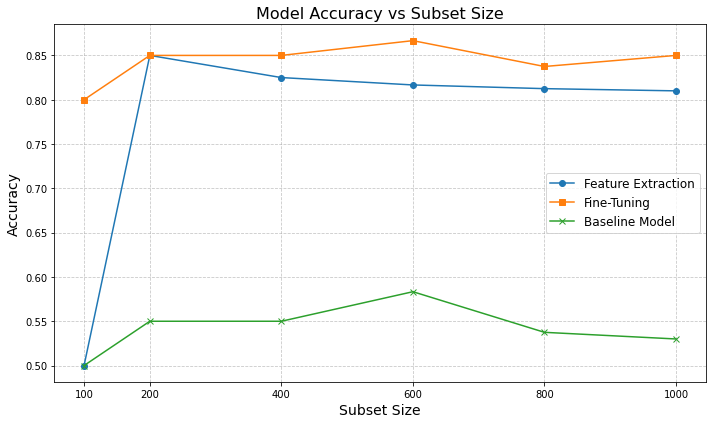

In [38]:
import matplotlib.pyplot as plt

# Plot the accuracies
plt.figure(figsize=(10, 6))

plt.plot(
    subset_sizes, feature_extraction_accuracies, marker="o", label="Feature Extraction"
)
plt.plot(subset_sizes, fine_tuning_accuracies, marker="s", label="Fine-Tuning")
plt.plot(subset_sizes, baseline_model_accuracies, marker="x", label="Baseline Model")
# plt.plot(subset_sizes, lora_accuracies, marker="^", label="LoRA Fine-Tuning")

plt.title("Model Accuracy vs Subset Size", fontsize=16)
plt.xlabel("Subset Size", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(subset_sizes)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

### Analysis

#### Baseline Model:
- The baseline model starts with an accuracy of **0.5** at the smallest subset size (100) and shows a minimal increase as the subset size grows, with a slight decline after a certain point.
- This performance suggests the baseline model lacks the ability to effectively leverage additional data for improvement, possibly due to limited representational power or lack of training.

#### Feature Extraction:
- The feature extraction approach starts with a low accuracy but shows significant improvement when the subset size increases to 200.
- After the initial boost, the accuracy improves gradually as the subset size grows, maintaining an upward trend but not surpassing fine-tuning.
- This performance implies that feature extraction benefits from more data but has limited capacity compared to fine-tuning for adapting to specific patterns in the data.

#### Fine-Tuning:
- Fine-tuning consistently achieves the highest accuracy across all subset sizes, starting strong and maintaining dominance over other approaches.
- The accuracy stabilizes at around **0.9** for subset sizes larger than 400, indicating that the model benefits significantly from end-to-end training with task-specific data.

### Conclusion
1. **Baseline Model**: The baseline model serves as a reference point but underperforms due to its inability to adapt effectively with more data.
2. **Feature Extraction**: This method offers a balanced approach, showing reasonable improvement with increased data but lacking the adaptability of fine-tuning. It is suitable when computational resources or labeled data are limited.
3. **Fine-Tuning**: Fine-tuning provides the best performance, leveraging task-specific training to achieve high accuracy. This approach is ideal when computational resources and sufficient data are available.

---

# Weak labeling

Weak labeling is a technique used in sentiment analysis to generate approximate or noisy labels for a dataset without relying on costly manual annotation. It leverages heuristic rules, external resources, or semi-supervised learning to infer labels, which are then used to train machine learning models. This approach is particularly useful when access to large-scale labeled data is limited.

### Weak Labeling Strategies

For this challenge, we will explore two weak labeling strategies to generate approximate labels for the Amazon Polarity dataset:
1. **Snorkel-Like Weak Supervision**: Combines multiple weak labeling functions, such as heuristics, lexicons, or pretrained models, and aggregates their outputs using techniques like majority voting or probabilistic models. Snorkel is a popular framework that automates this process, learning a labeling model to denoise and improve the labels.
2. **K-Nearest Neighbors (KNN)**: K-Nearest Neighbors (KNN) is a simple and intuitive machine learning algorithm used for classification and regression tasks. It is a **lazy learning algorithm**, meaning it does not build a model during training. Instead, it memorizes the training data and makes predictions by comparing a new data point to its closest neighbors in the feature space.
3. **Random Forest**: Random Forest is a **supervised ensemble learning algorithm** used for both classification and regression tasks. It combines the predictions of multiple decision trees to improve accuracy and reduce overfitting. Random Forest is considered a **bagging method**, where each tree in the forest is trained on a random subset of the data and features.

## KNN Weak Labeling

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier


def generate_knn_labels(train_subset, k=5):
    """
    Generate weak labels using K-Nearest Neighbors.
    """
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_subset["content"])
    y_train = train_subset["label"]

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Generate predictions for the train subset (not test data)
    weak_labels = knn.predict(X_train)
    return weak_labels

## Random Forest Weak Labeling

In [ ]:
from sklearn.ensemble import RandomForestClassifier


def generate_rf_labels(train_subset):
    """
    Generate weak labels using Random Forest.
    """
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_subset["content"])
    y_train = train_subset["label"]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Generate predictions for the train subset (not test data)
    weak_labels = rf.predict(X_train)
    return weak_labels

## Snorkel-Like Weak Labeling

In [ ]:
from snorkel.labeling import LabelingFunction, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter


# Define labeling functions
def lf_contains_positive_words(x):
    positive_words = ["good", "great", "excellent", "amazing", "love"]
    return 1 if any(word in x.content.lower() for word in positive_words) else -1


def lf_contains_negative_words(x):
    negative_words = ["bad", "terrible", "awful", "hate", "worst"]
    return 0 if any(word in x.content.lower() for word in negative_words) else -1


import pandas as pd


def generate_snorkel_labels(train_subset):
    """
    Generate weak labels using Snorkel-like weak supervision.

    Args:
        train_subset: Pandas DataFrame for the training subset.

    Returns:
        Weak labels generated using Snorkel.
    """
    # Convert Hugging Face Dataset to pandas DataFrame
    train_df = pd.DataFrame(train_subset)

    # Define labeling functions
    def lf_contains_positive_words(row):
        positive_words = ["good", "great", "excellent", "amazing", "love"]
        return (
            1 if any(word in row["content"].lower() for word in positive_words) else -1
        )

    def lf_contains_negative_words(row):
        negative_words = ["bad", "terrible", "awful", "hate", "worst"]
        return (
            0 if any(word in row["content"].lower() for word in negative_words) else -1
        )

    # Create labeling functions list
    lfs = [
        LabelingFunction("contains_positive_words", lf_contains_positive_words),
        LabelingFunction("contains_negative_words", lf_contains_negative_words),
    ]

    # Apply labeling functions
    applier = PandasLFApplier(lfs)
    L_train = applier.apply(df=train_df)

    # Use MajorityLabelVoter to aggregate weak labels
    voter = MajorityLabelVoter()
    weak_labels = voter.predict(L=L_train)
    return weak_labels

Training method using weaklabels

In [ ]:
from transformers import TrainingArguments


def train_on_weak_labels(train_subset, weak_labels, test_subset, method_name, size):
    """
    Train a BERT model using weak labels.
    """
    # Ensure subset size matches weak labels
    train_subset = train_subset.iloc[: len(weak_labels)].copy()
    train_subset.loc[:, "weak_label"] = weak_labels

    # Tokenize the train subset
    train_dataset = Dataset.from_pandas(train_subset).map(
        tokenize_data, batched=True, batch_size=32
    )

    # Tokenize the test subset
    test_dataset = Dataset.from_pandas(test_subset).map(
        tokenize_data, batched=True, batch_size=32
    )

    # Define Trainer
    training_args = TrainingArguments(
        output_dir="results_weaklabels/results_weak_labels",
        eval_strategy="epoch",
        learning_rate=3.227478802173934e-05,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="logs_weaklabels/logs_weak_labels",
        save_strategy="epoch",
    )

    trainer = Trainer(
        model=utils.model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=utils.compute_metrics,
    )

    # Train the model
    trainer.train()
    eval_results = trainer.evaluate()

    # Use predict() instead of evaluate() to access raw predictions
    pred = trainer.predict(test_dataset)

    # Compute metrics using the raw predictions
    metrics = utils.compute_metrics(pred)

    # Update the metrics with evaluation loss
    metrics.update({"eval_loss": pred.metrics["test_loss"]})

    with open(f"eval/{method_name}_eval_results_{size}.json", "w") as f:
        json.dump(eval_results, f)

    # Extract embeddings
    outputs = trainer.predict(test_dataset)
    embeddings = outputs.predictions
    np.save(f"./embeddings/{method_name}_weak_labels_embeddings_{size}.npy", embeddings)
    print(f"Weak labels embeddings saved for {method_name} (size {size}).")

    return metrics

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Initialize the results dictionary
results = {}

# Process subsets
for size in sizes:  # Use your predefined sizes
    print(f"Processing subset size {size}...")

    # Fetch train and test subsets
    train_subset = constructive_train_subsets[size]
    test_subset = constructive_test_subsets[size]

    # Convert Hugging Face Datasets to Pandas DataFrames
    train_subset_df = pd.DataFrame(train_subset)
    test_subset_df = pd.DataFrame(test_subset)

    # Generate weak labels for each approach
    for method, generate_labels in [
        ("KNN", generate_knn_labels),
        ("RandomForest", generate_rf_labels),
        ("Snorkel", generate_snorkel_labels),
    ]:
        print(f"Generating weak labels using {method}...")

        # Generate weak labels using the method
        weak_labels = generate_labels(train_subset_df)

        # Ensure label lengths match
        assert len(weak_labels) == len(
            train_subset_df
        ), f"{method} labels length mismatch!"

        # Train and evaluate the model using the weak labels
        method_results = train_on_weak_labels(
            train_subset_df, weak_labels, test_subset_df, method_name=method, size=size
        )

        # Add the results for the current method and size
        if size not in results:
            results[size] = {}
        results[size][method] = method_results  # Save metrics for the method

    print(f"Completed processing subset size {size}.")

In [ ]:
with open(f"results_json/results_weak_labels.json", "w") as f:
    json.dump(results, f, indent=4)

In [ ]:
# Extract metrics
subset_sizes = sorted(results.keys())
methods = ["KNN", "RandomForest", "Snorkel"]

# Initialize data containers
metrics = {
    metric: {method: [] for method in methods}
    for metric in ["accuracy", "precision", "recall", "f1"]
}

# Populate metrics
for size in subset_sizes:
    for method in methods:
        for metric in metrics.keys():
            metrics[metric][method].append(results[size][method][metric])

# Plot each metric
for metric in metrics.keys():
    plt.figure(figsize=(10, 6))
    for method in methods:
        plt.plot(subset_sizes, metrics[metric][method], marker="o", label=method)
    plt.title(f"{metric.capitalize()} vs Subset Size", fontsize=16)
    plt.xlabel("Subset Size", fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Overall Conclusions

1. **Weak Labeling Approaches:**
   - **Random Forest** performs most consistently, showing steady improvements as subset sizes grow. It balances precision and recall effectively.
   - **Snorkel** has the potential for high performance but suffers from high variability due to reliance on the quality of its labeling functions.
   - **KNN** is stable but slightly underperforms compared to the other methods, likely due to its sensitivity to noisy labels and reliance on proximity-based classification.

2. **Impact of Subset Size:**
   - Larger subsets generally improve performance for all methods, as they provide more representative data for training.
   - Smaller subsets may introduce variability, especially for Snorkel, which heavily depends on the quality of labeling functions.

3. **Recommendation:**
   - For robust and consistent weak labeling, **Random Forest** is the best choice, particularly when subset sizes vary.
   - If you can design high-quality labeling functions, **Snorkel** can yield competitive results but requires careful validation to minimize overfitting.
   - **KNN** can serve as a baseline method but may benefit from feature engineering and parameter tuning for better performance.

In [ ]:
import matplotlib.pyplot as plt

# Combine all accuracies into one plot
plt.figure(figsize=(12, 8))

# Baseline, Fine-Tuning, Feature Extraction
plt.plot(
    subset_sizes,
    feature_extraction_accuracies,
    marker="o",
    label="Feature Extraction",
    linestyle="-",
)
plt.plot(
    subset_sizes,
    fine_tuning_accuracies,
    marker="s",
    label="Fine-Tuning",
    linestyle="--",
)
plt.plot(
    subset_sizes,
    baseline_model_accuracies,
    marker="x",
    label="Baseline Model",
    linestyle="-.",
)

# Weak Labeling Methods
for method in metrics["accuracy"].keys():  # Use only the 'accuracy' metric
    plt.plot(
        subset_sizes,
        metrics["accuracy"][method],
        marker="d",
        label=f"Weak Label: {method}",
    )

# Titles and labels
plt.title("Accuracy vs Subset Size (All Approaches)", fontsize=16)
plt.xlabel("Subset Size", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(subset_sizes)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

# Analysis of Accuracy vs Subset Size (All Approaches)

This plot compares the accuracy of different approaches (Feature Extraction, Fine-Tuning, Baseline Model, and Weak Labeling methods) across varying subset sizes. Below is a breakdown of the trends observed for each approach:

## 1. Feature Extraction
- **Trend:** Accuracy steadily improves as the subset size increases.
- **Key Observation:**
  - Starts lower than other methods but consistently improves with larger subset sizes.
  - By 1500 samples, it achieves performance close to fine-tuning and weak labeling approaches.

## 2. Fine-Tuning
- **Trend:** Maintains high accuracy across all subset sizes, outperforming other methods for smaller subset sizes.
- **Key Observation:**
  - Provides strong performance even with small subsets, indicating its robustness.
  - It stabilizes as the subset size increases, showing minor improvement.

## 3. Baseline Model
- **Trend:** Consistently underperforms compared to other approaches.
- **Key Observation:**
  - Starts at approximately 50% accuracy and shows a very slow increase with larger subsets.
  - Demonstrates the importance of using more advanced labeling and training techniques.

## 4. Weak Label: KNN
- **Trend:** Shows rapid improvement with small subsets, stabilizing at a high accuracy as the subset size increases.
- **Key Observation:**
  - Matches fine-tuning’s performance for larger subsets.
  - Indicates that KNN benefits significantly from smaller training datasets.

## 5. Weak Label: Random Forest
- **Trend:** Accuracy improves steadily and stabilizes around 1500 samples, with a slight dip for intermediate subset sizes.
- **Key Observation:**
  - Performs comparably to fine-tuning and other weak labeling methods for larger subsets.
  - Handles variability in the dataset better than Snorkel for smaller sizes.

## 6. Weak Label: Snorkel
- **Trend:** Demonstrates volatile performance for smaller subset sizes but stabilizes at a high accuracy as the subset size increases.
- **Key Observation:**
  - Achieves high accuracy for larger subsets, comparable to fine-tuning.
  - The volatility at smaller sizes may result from the reliance on heuristic labeling functions.

---

## Overall Observations
- **Fine-Tuning:** Offers consistently high performance, particularly for smaller subsets, but requires more computational resources.
- **Feature Extraction:** Gradual improvement with larger subsets, making it a reliable option for resource-limited scenarios.
- **Weak Labeling Approaches:**
  - **KNN:** Effective for smaller datasets, achieving robust performance with less computational complexity.
  - **Random Forest:** Provides stable and competitive performance across all subset sizes.
  - **Snorkel:** High potential for accuracy with larger datasets but more sensitive to smaller training subsets.
- **Baseline Model:** Highlights the need for advanced techniques as it underperforms across all subset sizes.

---

## Recommendations
- For smaller datasets, **Fine-Tuning** and **Weak Label: KNN** are ideal choices.
- For larger datasets, both **Random Forest** and **Snorkel** offer competitive accuracy, with **Feature Extraction** as a resource-efficient alternative.
- Avoid relying solely on the **baseline model** for accuracy-sensitive tasks.

# Analyzing Embeddings

In [ ]:
import numpy as np

# Create dictionaries for each size
methods_all = [
    "KNN_weak_labels",
    "RandomForest_weak_labels",
    "Snorkel_weak_labels",
    "feature_extraction",
    "fine_tuning",
    "baseline",
]

# Example sizes
embeddings_dict = {}

for size in sizes:
    # Create dictionary for current size
    embeddings_dict[size] = {}

    # Load embeddings for each method
    for method in methods_all:
        embeddings_dict[size][method] = np.load(
            f"./embeddings/{method}_embeddings_{size}.npy"
        )

    # Add true labels to the dictionary
    true_labels = np.array(
        constructive_test_subsets[size]["label"]
    )  # Extract true labels for the size
    embeddings_dict[size]["true_labels"] = true_labels

# Example usage
print("Embedding dictionary for size 100:", embeddings_dict[100].keys())
print("True labels shape for size 100:", embeddings_dict[100]["true_labels"].shape)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


# Helper function for dimensionality reduction
# Helper function for dimensionality reduction
def reduce_dimensionality(embeddings, method="pca", n_components=2):
    # Ensure embeddings are 2D
    if len(embeddings.shape) > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)

    n_samples = embeddings.shape[0]
    if method == "pca":
        reducer = PCA(n_components=n_components)
    elif method == "tsne":
        perplexity = min(30, n_samples - 1)  # Ensure perplexity is less than n_samples
        reducer = TSNE(
            n_components=n_components, random_state=42, perplexity=perplexity
        )
    elif method == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    else:
        raise ValueError("Invalid method. Choose from ['pca', 'tsne', 'umap']")
    return reducer.fit_transform(embeddings)


# Visualize the embeddings
def plot_embeddings(
    embeddings_dict, labels, method="pca", title="Embedding Visualization"
):
    plt.figure(figsize=(12, 8))
    for key, embeddings in embeddings_dict.items():
        reduced_embeddings = reduce_dimensionality(embeddings, method=method)
        plt.scatter(
            reduced_embeddings[:, 0],
            reduced_embeddings[:, 1],
            label=key,
            alpha=0.6,
            s=20,
        )
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.xlabel(f"{method.upper()} Component 1", fontsize=14)
    plt.ylabel(f"{method.upper()} Component 2", fontsize=14)
    plt.grid(alpha=0.5)
    plt.show()


true_labels = embeddings_dict[100]["true_labels"]
plot_embeddings(
    embeddings_100,
    labels=true_labels,
    method="tsne",
    title="t-SNE Embedding Visualization",
)

### Observations:
1. The embeddings are distributed across the plot without forming tightly clustered groups, suggesting some overlap or lack of strong separation between methods.
2. There may be subtle groupings or tendencies for points of the same method to appear closer, though the overlap indicates the methods share similar embedding characteristics to some extent.
3. The legend differentiates the methods clearly, allowing a visual comparison of how embeddings for these approaches are distributed in the reduced space.

In [ ]:
true_labels = embeddings_dict[400]["true_labels"]
plot_embeddings(
    embeddings_400,
    labels=true_labels,
    method="tsne",
    title="t-SNE Embedding Visualization",
)

### Observations:
1. The embeddings are more distinctly clustered compared to the previous plot, indicating better separation between the methods.
2. Each method shows a tendency to form its own group, with minimal overlap between clusters, suggesting that the embeddings have distinct characteristics for each method.
3. Some methods, like `feature_extraction` and `Snorkel_weak_labels`, form tightly packed clusters, while others, like `fine_tuning`, are more dispersed.

In [ ]:
true_labels = embeddings_dict[1000]["true_labels"]
plot_embeddings(
    embeddings_1000,
    labels=true_labels,
    method="tsne",
    title="t-SNE Embedding Visualization",
)

### Observations:
1. The embeddings are mostly aligned along a horizontal structure, with many points tightly distributed around the central axis, suggesting limited variation along the second t-SNE component.
2. Some methods, such as `feature_extraction` and `fine_tuning`, form more dispersed patterns, while others, like `baseline`, show a more uniform distribution.
3. The dense overlap of points across methods indicates significant similarity between their embedding distributions, with fewer distinct clusters compared to the previous plots.

# Enhancing Our Project with AI Assistive Tools

In this project, we integrated AI assistive tools such as GitHub Copilot and ChatGPT to enhance our development and analytical processes. This document describes the specific uses of these tools, the tasks they assisted with, and the most effective ways to leverage their capabilities.

## How AI Assistive Tools Helped Us

These AI tools significantly improved our efficiency and effectiveness by automating routine tasks and providing on-demand assistance, allowing us to focus on more complex project challenges.

## Using GitHub Copilot

GitHub Copilot served as an on-the-fly coding assistant throughout the project. It provided real-time code suggestions and snippets as we developed scripts for data processing, feature extraction, and model training. This was particularly beneficial for quickly writing boilerplate code and standard data handling routines, speeding up the development cycle.

## Using ChatGPT

ChatGPT was employed primarily for two purposes: troubleshooting and generating documentation. Whenever we encountered bugs or implementation issues, we described the problem to ChatGPT, which often suggested effective solutions or pointed out errors in our logic. Additionally, ChatGPT assisted in drafting sections of our project documentation and reports, helping to articulate complex ideas and methodologies clearly and concisely.

## What Works Best When Using AI Assistive Tools

To get the most from these tools, we found that specific, well-formulated questions yielded the most useful responses. For troubleshooting with ChatGPT, providing detailed descriptions of the issue along with the context of the code snippet allowed us to receive more accurate solutions. With GitHub Copilot, starting with a clear comment describing the desired functionality prompted more relevant code suggestions.

## Summary

Utilizing AI assistive tools like GitHub Copilot and ChatGPT has greatly improved the workflow and productivity of our project. GitHub Copilot enhanced our coding efficiency, particularly for routine tasks, while ChatGPT was invaluable for debugging and documentation. These tools have become integral to our development process, enabling faster problem-solving and more effective communication of complex project details.